In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, roc_auc_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

### Read in PCA train dataset

In [31]:
df = pd.read_csv('../data/PCA-nsl_kdd_train.csv')
df.sample(5)

,pc01,pc02,pc03,pc04,pc05,pc06,pc07,pc08,pc09,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,attack_type
6215,2.666671,1.552944,-0.186686,-0.123586,-0.431781,-0.100841,-0.048869,-0.176220,0.168808,0.145092,0.199686,-0.113893,-0.283411,-0.108712,-0.673363,-0.123301,-0.106066,-0.200874,normal
66955,-2.987308,1.003639,0.787690,0.130376,0.433437,0.412167,-0.072791,-0.198254,0.136889,0.166906,0.276765,-0.109872,-0.307958,-0.050789,-0.268658,0.529173,0.060994,-0.390827,neptune
96540,-2.884419,0.822480,1.090304,0.127204,0.422119,0.258248,-0.027658,-0.050639,0.021844,0.096536,0.187452,-0.056590,-0.289143,-0.177782,0.079886,0.617908,0.126283,-0.325252,neptune
29616,2.287170,1.039312,-0.566001,-0.363117,-0.006717,0.801712,-0.098118,-0.404713,0.335532,0.012804,0.125148,-0.191655,-0.108117,0.194773,-0.413855,-1.408563,-0.371580,0.823436,normal
63595,2.668041,1.528743,-0.434312,-0.005282,-0.366284,-0.005577,-0.072229,-0.247072,0.227876,0.225560,0.236767,-0.144942,-0.323035,-0.093040,-0.888640,-0.232206,-0.165208,-0.260175,normal


### Remove target attribute

In [32]:
X = df.drop(columns=['attack_type'], inplace=False)

### Determine best k (cluster count) using Silhouette Score

In [33]:
# Calculate the Silhouette Scores
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)  # store the score
    print(f"k={k}, silhouette score={score:.4f}")

k=2, silhouette score=0.2907
k=3, silhouette score=0.3061
k=4, silhouette score=0.4442
k=5, silhouette score=0.4652
k=6, silhouette score=0.4907
k=7, silhouette score=0.4821
k=8, silhouette score=0.4836
k=9, silhouette score=0.4848
k=10, silhouette score=0.4822


2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  

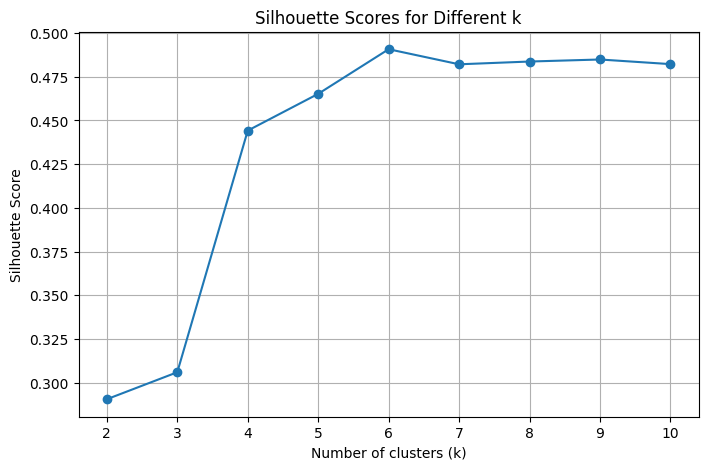

In [34]:
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

### Determine best k (cluster count) using the Elbow Method

In [35]:
distorsions = []
results = []
for k in range(2, 20):
  kmeans = KMeans(n_clusters=k, random_state=24)
  kmeans.fit(X)
  distorsions.append(kmeans.inertia_)

In [36]:
# Method 1: Elbow method using the "kneedle" algorithm (distance from line)
# Find the point with maximum distance from the line connecting first and last points
def find_elbow(values):
  # Normalize the values
  n_points = len(values)
  all_coords = np.vstack((range(n_points), values)).T
  first_point = all_coords[0]
  last_point = all_coords[-1]

  # Vector from first to last point
  line_vec = last_point - first_point
  line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))

  # Vector from first point to each point
  vec_from_first = all_coords - first_point

  # Distance from each point to the line
  scalar_product = np.sum(vec_from_first * line_vec_norm, axis=1)
  vec_to_line = vec_from_first - np.outer(scalar_product, line_vec_norm)
  dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))

  # Find the index with maximum distance
  elbow_idx = np.argmax(dist_to_line)
  return elbow_idx


elbow_idx = find_elbow(distorsions)
optimal_k = elbow_idx + 2  # +2 because we started at k=2

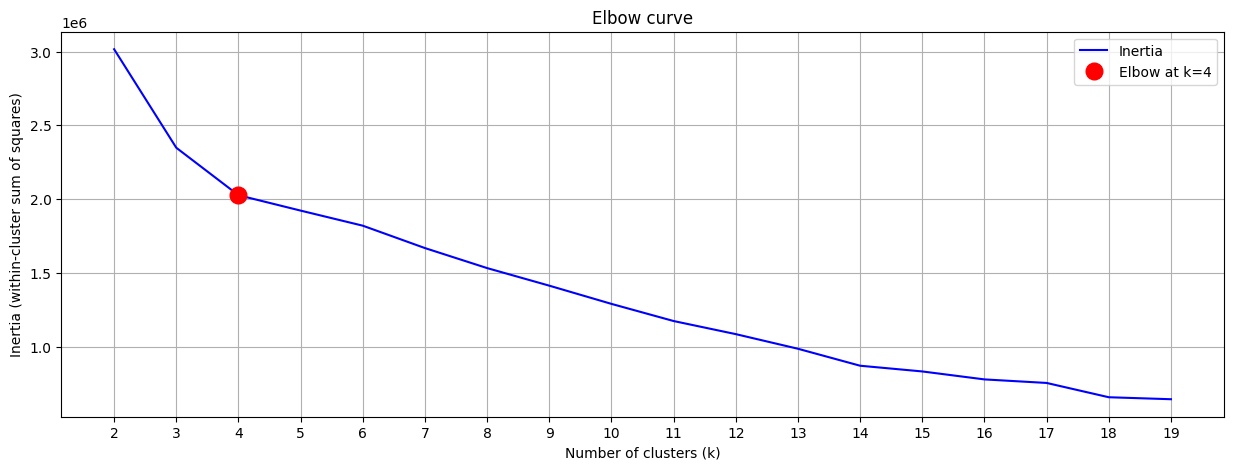

In [37]:
# Plotting
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions, 'b-', label='Inertia')
plt.plot(
  optimal_k,
  distorsions[elbow_idx],
  'ro',
  markersize=12,
  label=f'Elbow at k={optimal_k}',
)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.xticks(range(2, 20))
plt.legend()
plt.show()

## Silhouette score

Note: This cell takes awhile

In [38]:
# Create a simplified label: "normal" stays; everything else becomes "attack"
df['label_simple'] = df['attack_type'].apply(lambda x: 'normal' if x == 'normal' else 'attack')


### Train KMEANS model with optimal k values

An average of the Silhouette Score and Elbow Algorithm were used to determine the optimal number of clusters. Below are the results further detailed by normal and attack type.

In [39]:
# Train KMeans
k = 5
kmeans_final = KMeans(n_clusters=k, random_state=24)
cluster_labels = kmeans_final.fit_predict(X)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

# Print cluster count and description
print("="*80)
print(f"CLUSTER ANALYSIS FOR K={k} (simplified labels: attack vs normal)")
print("="*80)

# Iterate over clusters and explain results
for i in range(k):
    cluster_data = df[df['cluster'] == i]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(df)) * 100
    
    print(f"\n--- Cluster {i} ---")
    print(f"Size: {cluster_size:,} samples ({cluster_pct:.2f}%)")
    
    # Use simplified labels
    simplified_dist = cluster_data['label_simple'].value_counts()
    print("\nAttack vs Normal distribution:")
    for label, count in simplified_dist.items():
        pct = (count / cluster_size) * 100
        print(f"  {label}: {count:,} ({pct:.2f}%)")

CLUSTER ANALYSIS FOR K=5 (simplified labels: attack vs normal)

--- Cluster 0 ---
Size: 7,695 samples (6.11%)

Attack vs Normal distribution:
  attack: 5,737 (74.55%)
  normal: 1,958 (25.45%)

--- Cluster 1 ---
Size: 16,879 samples (13.40%)

Attack vs Normal distribution:
  normal: 15,724 (93.16%)
  attack: 1,155 (6.84%)

--- Cluster 2 ---
Size: 42,027 samples (33.36%)

Attack vs Normal distribution:
  attack: 41,543 (98.85%)
  normal: 484 (1.15%)

--- Cluster 3 ---
Size: 38,820 samples (30.82%)

Attack vs Normal distribution:
  normal: 37,858 (97.52%)
  attack: 962 (2.48%)

--- Cluster 4 ---
Size: 20,552 samples (16.31%)

Attack vs Normal distribution:
  normal: 11,319 (55.07%)
  attack: 9,233 (44.93%)


### Generate a graph of clusters by type

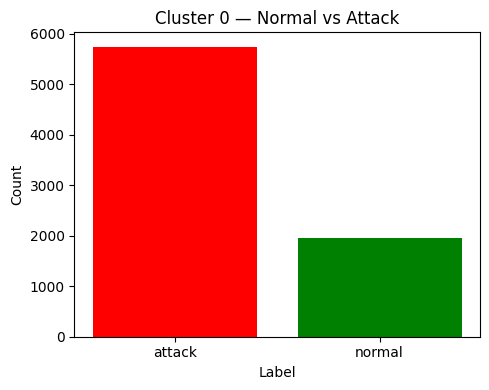

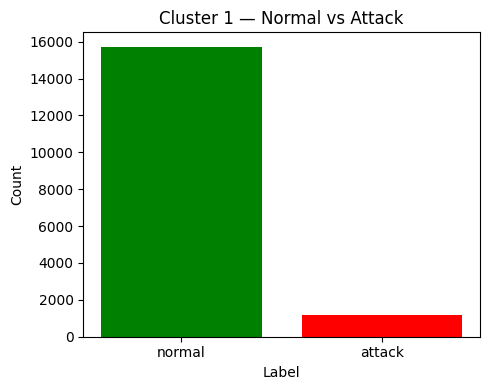

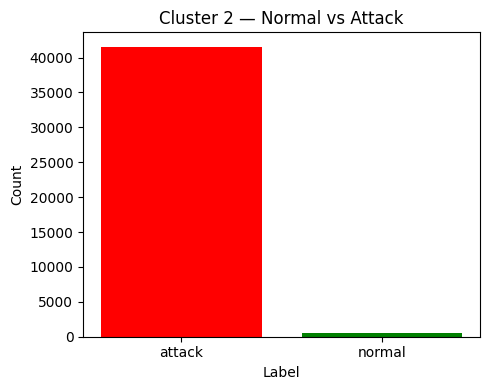

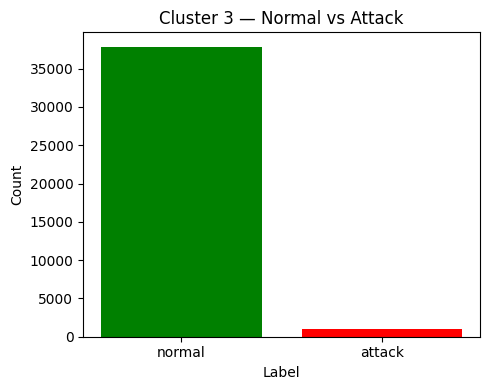

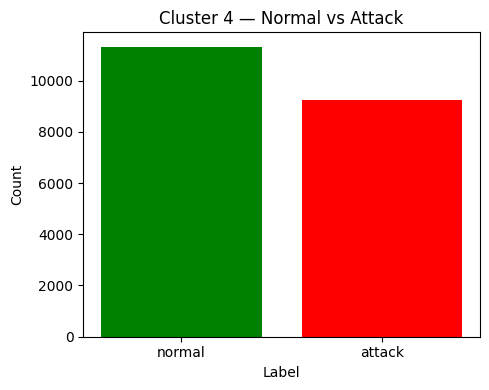

In [40]:
k = df['cluster'].nunique()
for i in range(k):
    cluster_data = df[df['cluster'] == i]

    # Count normal vs attack
    counts = cluster_data['label_simple'].value_counts()

    # Get color by type
    colors = ['green' if label == 'normal' else 'red' for label in counts.index]

    # Plot
    plt.figure(figsize=(5,4))
    plt.bar(counts.index, counts.values, color=colors)
    
    plt.title(f"Cluster {i} — Normal vs Attack")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

From the results, we can see that KMEANS can generate clusters well for some instances of normal and attack types; however, it is unable to correctly generate clusters in every case. This makes it an unreliable solution and not the best option for classifying future network traffic. It is likely that this model is too simple for the data.

In [41]:
# Identify which cluster corresponds to "attack"
# Compute the attack rate per cluster
attack_rates = (
    df.groupby('cluster')['label_simple']
      .apply(lambda s: (s == 'attack').mean())
)

# Choose the cluster with the highest attack proportion
attack_cluster = attack_rates.idxmax()

# Convert cluster assignments into attack predictions (1 for attack cluster, 0 otherwise)
df['pred_attack'] = (df['cluster'] == attack_cluster).astype(int)

# Convert true labels to binary
df['true_attack'] = (df['label_simple'] == 'attack').astype(int)

# Compute AUC-ROC
auc = roc_auc_score(df['true_attack'], df['pred_attack'])

print("\n" + "="*80)
print("AUC-ROC Evaluation of KMeans (treating highest-attack cluster as 'attack')")
print("="*80)
print(f"AUC-ROC: {auc:.4f}")
print(f"Cluster identified as 'attack': {attack_cluster}")
print("Attack rate per cluster:")
print(attack_rates)



AUC-ROC Evaluation of KMeans (treating highest-attack cluster as 'attack')
AUC-ROC: 0.8507
Cluster identified as 'attack': 2
Attack rate per cluster:
cluster
0    0.745549
1    0.068428
2    0.988484
3    0.024781
4    0.449251
Name: label_simple, dtype: float64


In [42]:
# Precision, Recall, F1
precision = precision_score(df['true_attack'], df['pred_attack'])
recall = recall_score(df['true_attack'], df['pred_attack'])
f1 = f1_score(df['true_attack'], df['pred_attack'])

print("\nPrecision / Recall / F1 Evaluation")
print("="*80)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



Precision / Recall / F1 Evaluation
Precision: 0.9885
Recall:    0.7086
F1 Score:  0.8254
